<a href="https://colab.research.google.com/github/Sam-Macpherson/PredictingNBAWithMachineLearning/blob/master/code/basketball_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset.
data = pd.read_csv('https://raw.githubusercontent.com/Sam-Macpherson/PredictingNBAWithMachineLearning/master/data/training_examples_1997-2019.csv')
dftrain, dfeval = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
y_train = dftrain.pop('outcome')
y_eval = dfeval.pop('outcome')

In [13]:
import tensorflow as tf
tf.random.set_seed(123)

In [14]:
dftrain.head()

,team0_sn_fg,team0_sn_fga,team0_sn_fgp,team0_sn_3pfg,team0_sn_3pfga,team0_sn_fg_3pfgp,team0_sn_2pfg,team0_sn_2pfga,team0_sn_2pfgp,team0_sn_ft,team0_sn_fta,team0_sn_ftp,team0_sn_orb,team0_sn_drb,team0_sn_trb,team0_sn_ast,team0_sn_stl,team0_sn_blk,team0_sn_tov,team0_sn_pf,team0_sn_pts,team1_sn_fg,team1_sn_fga,team1_sn_fgp,team1_sn_3pfg,team1_sn_3pfga,team1_sn_fg_3pfgp,team1_sn_2pfg,team1_sn_2pfa,team1_sn_2pfgp,team1_sn_ft,team1_sn_fta,team1_sn_ftp,team1_sn_orb,team1_sn_drb,team1_sn_trb,team1_sn_ast,team1_sn_stl,team1_sn_blk,team1_sn_tov,team1_sn_pf,team1_sn_pts,team0_matchup_fg,team0_matchup_fga,team0_matchup_fgp,team0_matchup_3pfg,team0_matchup_3pfga,team0_matchup_fg_3pfgp,team0_matchup_ft,team0_matchup_fta,team0_matchup_ftp,team0_matchup_orb,team0_matchup_drb,team0_matchup_trb,team0_matchup_ast,team0_matchup_stl,team0_matchup_blk,team0_matchup_tov,team0_matchup_pf,team0_matchup_pts,team1_matchup_fg,team1_matchup_fga,team1_matchup_fgp,team1_matchup_3pfg,team1_matchup_3pfga,team1_matchup_fg_3pfgp,team1_matchup_ft,team1_matchup_fta,team1_matchup_ftp,team1_matchup_orb,team1_matchup_drb,team1_matchup_trb,team1_matchup_ast,team1_matchup_stl,team1_matchup_blk,team1_matchup_tov,team1_matchup_pf,team1_matchup_pts
515,34.8,82.1,0.424,8.5,23.7,0.359,26.3,58.4,0.450,18.3,23.9,0.764,10.9,31.3,42.2,21.0,9.7,3.6,13.6,21.7,96.4,34.4,75.7,0.454,3.6,9.8,0.372,30.7,65.9,0.466,20.2,26.7,0.756,11.6,28.4,40.1,23.1,9.9,5.1,17.3,23.6,92.5,37.400000,84.800000,0.441000,7.000000,22.800000,0.310200,16.200000,20.200000,0.798200,10.00,29.400000,39.400000,25.600000,7.000000,2.600000,13.400000,24.400000,98.000,37.800000,81.800000,0.460600,9.400000,29.000000,0.326000,21.800000,27.000000,0.829600,11.800,33.600000,45.400000,22.400000,6.400,5.600000,14.400,21.000000,106.800000
29,35.6,75.9,0.469,4.9,12.5,0.390,30.7,63.3,0.485,19.9,26.0,0.764,10.7,28.6,39.3,23.0,7.9,4.5,14.2,22.7,96.0,34.9,78.2,0.447,4.7,13.9,0.335,30.3,64.3,0.471,17.1,22.1,0.772,11.9,29.7,41.6,21.8,7.7,3.4,15.2,23.7,91.6,32.250000,70.750000,0.458000,5.500000,14.000000,0.454500,19.000000,23.250000,0.851500,8.25,28.000000,36.250000,20.250000,5.750000,3.500000,17.750000,26.000000,89.000,33.500000,76.500000,0.438750,2.500000,9.750000,0.256750,19.000000,24.000000,0.757750,9.750,25.000000,34.750000,16.500000,10.250,3.750000,13.250,23.750000,88.500000
274,33.2,74.3,0.447,5.0,13.6,0.365,28.2,60.7,0.465,19.0,25.7,0.740,12.1,28.2,40.3,20.2,8.9,4.2,15.8,22.8,90.4,33.7,78.9,0.428,4.5,13.5,0.330,29.3,65.4,0.448,17.5,25.0,0.700,13.8,28.9,42.7,21.3,9.9,4.3,16.4,18.7,89.5,34.857143,74.571429,0.467429,6.571429,15.285714,0.439000,21.714286,27.571429,0.782429,11.00,27.285714,38.285714,22.142857,7.285714,5.428571,10.714286,23.142857,98.000,32.571429,68.428571,0.477857,2.857143,8.285714,0.364143,20.285714,32.428571,0.623571,10.000,27.571429,37.571429,17.714286,6.000,4.285714,15.000,22.142857,88.285714
576,39.8,86.0,0.463,8.5,24.0,0.356,31.2,62.0,0.504,18.5,25.8,0.717,11.5,30.0,41.4,23.8,9.1,5.7,16.0,23.6,106.5,35.2,78.0,0.451,4.0,12.8,0.309,31.2,65.2,0.479,20.0,27.1,0.737,13.2,30.8,44.0,21.5,7.1,5.7,16.9,22.7,94.3,43.750000,86.375000,0.507000,11.875000,30.000000,0.399125,22.875000,28.875000,0.788625,8.00,37.625000,45.625000,30.000000,10.125000,8.125000,14.250000,18.500000,122.250,37.375000,89.000000,0.419125,11.000000,32.000000,0.347125,17.750000,22.250000,0.787875,9.125,31.500000,40.625000,18.875000,8.375,4.250000,15.375,21.625000,103.500000
434,35.3,75.5,0.468,3.7,10.5,0.350,31.7,64.9,0.488,18.2,26.4,0.688,12.0,32.2,44.2,22.4,6.3,6.9,16.1,21.1,92.5,36.5,74.5,0.490,3.0,8.2,0.372,33.5,66.4,0.504,24.9,32.2,0.773,11.7,29.3,41.1,25.2,7.9,5.0,15.4,23.9,101.0,37.000000,78.500000,0.471500,8.250000,20.500000,0.409875,19.875000,25.500000,0.785125,7.75,33.375000,41.125000,21.125000,7.250000,5.500000,13.625000,20.375000,102.125,34.500000,85.250000,0.405750,3.000000,12.375000,0.243000,19.375000,26.500000,0.733500,14.125,31.875000,46.000000,17.000000,7.625,7.250000,12.875,21.375000,91.375000


In [15]:
dftrain.describe()

,team0_sn_fg,team0_sn_fga,team0_sn_fgp,team0_sn_3pfg,team0_sn_3pfga,team0_sn_fg_3pfgp,team0_sn_2pfg,team0_sn_2pfga,team0_sn_2pfgp,team0_sn_ft,team0_sn_fta,team0_sn_ftp,team0_sn_orb,team0_sn_drb,team0_sn_trb,team0_sn_ast,team0_sn_stl,team0_sn_blk,team0_sn_tov,team0_sn_pf,team0_sn_pts,team1_sn_fg,team1_sn_fga,team1_sn_fgp,team1_sn_3pfg,team1_sn_3pfga,team1_sn_fg_3pfgp,team1_sn_2pfg,team1_sn_2pfa,team1_sn_2pfgp,team1_sn_ft,team1_sn_fta,team1_sn_ftp,team1_sn_orb,team1_sn_drb,team1_sn_trb,team1_sn_ast,team1_sn_stl,team1_sn_blk,team1_sn_tov,team1_sn_pf,team1_sn_pts,team0_matchup_fg,team0_matchup_fga,team0_matchup_fgp,team0_matchup_3pfg,team0_matchup_3pfga,team0_matchup_fg_3pfgp,team0_matchup_ft,team0_matchup_fta,team0_matchup_ftp,team0_matchup_orb,team0_matchup_drb,team0_matchup_trb,team0_matchup_ast,team0_matchup_stl,team0_matchup_blk,team0_matchup_tov,team0_matchup_pf,team0_matchup_pts,team1_matchup_fg,team1_matchup_fga,team1_matchup_fgp,team1_matchup_3pfg,team1_matchup_3pfga,team1_matchup_fg_3pfgp,team1_matchup_ft,team1_matchup_fta,team1_matchup_ftp,team1_matchup_orb,team1_matchup_drb,team1_matchup_trb,team1_matchup_ast,team1_matchup_stl,team1_matchup_blk,team1_matchup_tov,team1_matchup_pf,team1_matchup_pts
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,35.906019,79.295922,0.452903,5.130485,14.618252,0.349039,30.783301,64.673398,0.476192,19.600194,26.497864,0.740650,12.418641,29.821553,42.241165,22.040583,8.399417,5.236117,15.240971,22.281942,96.521942,35.977282,79.343689,0.453522,5.185631,14.737476,0.349944,30.798058,64.603301,0.476913,19.651262,26.538058,0.741625,12.348932,29.852427,42.202524,22.103883,8.429515,5.246214,15.198835,22.337864,96.770485,35.827795,80.297131,0.447021,7.064075,19.962266,0.349752,18.822453,25.058809,0.752154,10.883384,31.126530,42.009914,20.576117,7.327024,4.872391,13.269152,22.007271,97.542119,35.863480,80.424642,0.446820,7.003639,19.810512,0.349015,18.715878,24.910266,0.752484,10.871135,31.047589,41.918724,20.548612,7.372406,4.858955,13.183480,22.065635,97.446476
std,1.871240,3.434241,0.017662,1.607395,4.350591,0.025395,1.994807,3.861736,0.020180,1.760687,2.615818,0.033002,1.366299,1.460365,1.588521,2.010363,1.133355,1.072751,1.011746,1.424236,4.842384,1.861208,3.385839,0.017945,1.641600,4.439947,0.025418,2.034478,3.889111,0.020429,1.818734,2.744295,0.033606,1.368722,1.433591,1.556102,2.003786,1.118200,1.060266,1.005703,1.407022,4.849231,3.365541,5.365458,0.028631,2.724215,6.796286,0.051240,3.151359,4.221152,0.048068,2.121619,2.920121,3.491079,3.130501,1.417583,1.412111,1.936660,2.557681,8.736428,3.295601,5.310608,0.028789,2.707825,6.770923,0.051048,3.226617,4.286887,0.048675,2.140867,2.892068,3.544219,3.050539,1.423079,1.378139,1.925769,2.570163,8.663542
min,30.800000,74.300000,0.409000,2.000000,7.400000,0.264000,26.300000,58.300000,0.431000,16.400000,21.800000,0.679000,10.100000,26.100000,38.500000,15.600000,6.300000,3.400000,13.300000,18.300000,86.300000,30.800000,74.300000,0.409000,2.000000,7.400000,0.264000,26.300000,58.300000,0.431000,16.400000,21.800000,0.679000,10.100000,26.100000,38.500000,15.600000,6.300000,3.400000,13.300000,18.300000,86.300000,25.000000,64.250000,0.315667,1.000000,5

In [16]:
dftrain.shape[0], dfeval.shape[0]

(515, 129)

In [17]:
CATEGORICAL_COLUMNS = []
NUMERIC_COLUMNS = ['team0_sn_fg','team0_sn_fgp','team0_sn_3pfg',
                   'team0_sn_fg_3pfgp','team0_sn_2pfg','team0_sn_2pfgp',
                   'team0_sn_ft','team0_sn_ftp','team0_sn_orb',
                   'team0_sn_drb','team0_sn_trb','team0_sn_ast','team0_sn_stl','team0_sn_blk',
                   'team0_sn_tov','team0_sn_pf','team0_sn_pts','team1_sn_fg',
                   'team1_sn_fgp','team1_sn_3pfg','team1_sn_fg_3pfgp','team1_sn_2pfg',
                   'team1_sn_2pfgp','team1_sn_ft','team1_sn_ftp','team1_sn_orb',
                   'team1_sn_drb','team1_sn_trb','team1_sn_ast','team1_sn_stl',
                   'team1_sn_blk','team1_sn_tov','team1_sn_pf','team1_sn_pts',
                   'team0_matchup_fg','team0_matchup_fgp','team0_matchup_3pfg',
                   'team0_matchup_fg_3pfgp','team0_matchup_ft','team0_matchup_ftp',
                   'team0_matchup_orb','team0_matchup_drb','team0_matchup_trb',
                   'team0_matchup_ast','team0_matchup_stl','team0_matchup_blk',
                   'team0_matchup_tov','team0_matchup_pf','team0_matchup_pts',
                   'team1_matchup_fg','team1_matchup_fgp','team1_matchup_3pfg',
                   'team1_matchup_fg_3pfgp','team1_matchup_ft','team1_matchup_ftp',
                   'team1_matchup_orb','team1_matchup_drb','team1_matchup_trb',
                   'team1_matchup_ast','team1_matchup_stl','team1_matchup_blk','team1_matchup_tov',
                   'team1_matchup_pf','team1_matchup_pts']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float64))

In [18]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [23]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=300)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.860465
accuracy_baseline         0.503876
auc                       0.946875
auc_precision_recall      0.948883
average_loss              0.415574
label/mean                0.503876
loss                      0.415574
precision                 0.873016
prediction/mean           0.504845
recall                    0.846154
global_step             300.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpes4od0ug/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


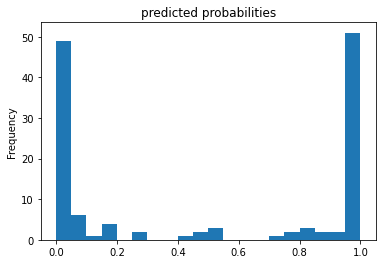

In [21]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

[0.       0.       0.       0.015625 0.015625 0.03125  0.03125  0.046875
 0.046875 0.0625   0.0625   0.109375 0.109375 0.125    0.125    0.171875
 0.171875 0.203125 0.203125 0.25     0.25     0.296875 0.296875 0.328125
 0.328125 0.53125  0.53125  1.      ]
[0.         0.01538462 0.67692308 0.67692308 0.70769231 0.70769231
 0.72307692 0.72307692 0.73846154 0.73846154 0.86153846 0.86153846
 0.87692308 0.87692308 0.89230769 0.89230769 0.90769231 0.90769231
 0.93846154 0.93846154 0.95384615 0.95384615 0.96923077 0.96923077
 0.98461538 0.98461538 1.         1.        ]


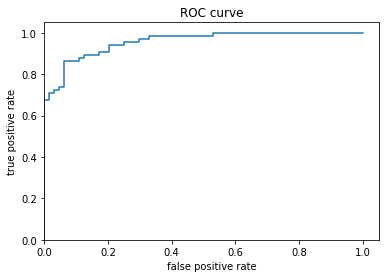

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()